<a href="https://colab.research.google.com/github/armiro/Covid19-Detection/blob/master/unet_lung_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [0]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Input, concatenate
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

In [0]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [0]:
segmentor = unet(input_size=(320, 320, 1))
segmentor.load_weights('/content/drive/My Drive/cxr_reg_weights.hdf5')

In [14]:
segmentor.input_shape

(None, 320, 320, 1)

number of total dataset images: 100
number of total dataset labels: 100
dataset shape: (100, 320, 320, 1)


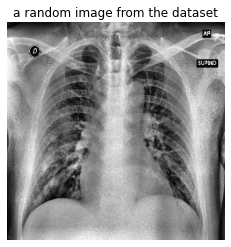

In [43]:
X = np.load(file='/content/drive/My Drive/Datasets/covid_cxr_dataset/cxr_samples.npy')
y = np.load(file='/content/drive/My Drive/Datasets/covid_cxr_dataset/cxr_labels.npy')
X = X[:100]
y = y[:100]

X = np.array([cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8)).apply(image) for image in X])
X = np.array([np.expand_dims(a=image, axis=-1) for image in X])

X = np.array([X[idx] / 255. for idx in range(len(X))])

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

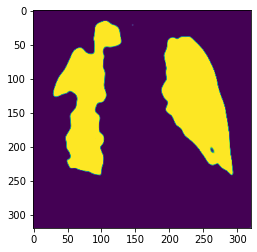

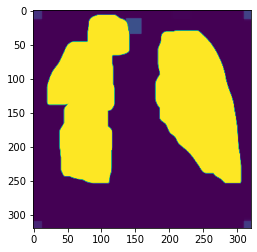

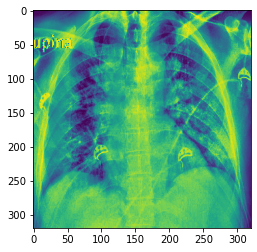

In [59]:
test_img = np.expand_dims(X[98], axis=0)
sample = segmentor(test_img)
plt.imshow(np.squeeze(sample))
plt.show()
kernel = np.ones((8, 8))
sample = cv2.dilate(np.squeeze(sample), kernel=kernel, iterations=3)
plt.imshow(np.squeeze(sample))
plt.show()
plt.imshow(test_img.squeeze())
plt.show()
